# Introdução

Este documento apresenta a dedução e aplicação do estimador para o parâmetro da distribuição uniforme discreta obtido pelo **método de Máxima Verossimilhança (EMV)**. 

O objetivo é avaliar o desempenho desse estimador por meio de simulações no software R, observando métricas como **viés**, **erro quadrático médio (REQM)** e a **distribuição das estimativas**.

A distribuição uniforme discreta considerada possui suporte em $\{1, 2, ..., \theta\}$, sendo $\theta$ o parâmetro a ser estimado a partir de amostras geradas artificialmente.

Este estudo foi desenvolvido como parte de um trabalho acadêmico para a disciplina de **Estatística II**, com o propósito de explorar métodos clássicos de estimação e validar seus comportamentos via simulação computacional.

## Estimador pelo Método dos Momentos

Com base na definição de momento para a distribuição uniforme discreta, obtemos o seguinte estimador para o parâmetro $\theta$:

$$
\hat{\theta}_{EMV} = Y_n = max\{x_1,x_2,x_3,...,x_n\},
$$
Onde $Y_n$ é o máximo retirado da amostra.


Juntamente com o viés que:
$$
B(Y_n) =   -\frac{1}{\theta^n}\sum_{y=1}^{\theta-1}y^n,
$$
nota-se que, o viés $B(Y_n) \leq 0$, portanto o estimador tende a subestimar o valor definitivo de $\theta$.

E o Erro Quadrático Médio (EQM):

$$
EQM({Y_n}) = -\frac{1}{\theta^n}\sum_{y=1}^{\theta -1}y^n(2y+1) + \frac{2}{\theta^{n-1}}\sum_{y=1}^{\theta-1}y^n.
$$
Para descobrir o tamanho da amostra $n$ que satisfaça a propriedade $P(Y_n = \theta)$ = 1,

$$
n = -\frac{d}{log_{10}(\frac{\theta-1}{\theta})}, \theta \neq 1.

$$
sendo $d$ o número de "erro" tolerável de casas decimais para a probabilidade final.

Estes resultados foram deduzidos analiticamente e serão utilizados a seguir na simulação.

# Simulação

Instalando e carregando os pacotes necessários


In [1]:
if (!require(tidyverse)) install.packages('tidyverse')
if (!require(purrr)) install.packages('purrr')
if (!require(ggplot2)) install.packages('ggplot2')
if (!require(cowplot)) install.packages('cowplot')


library('tidyverse')
library('purrr')
library('ggplot2')
library('cowplot')


Carregando pacotes exigidos: tidyverse

Warning message:
"package 'tidyverse' was built under R version 4.3.3"
Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'tibble' was built under R version 4.3.2"
Warning message:
"package 'tidyr' was built under R version 4.3.2"
Warning message:
"package 'readr' was built under R version 4.3.2"
Warning message:
"package 'purrr' was built under R version 4.3.3"
Warning message:
"package 'dplyr' was built under R version 4.3.2"
Warning message:
"package 'stringr' was built under R version 4.3.3"
Warning message:
"package 'forcats' was built under R version 4.3.3"
Warning message:
"package 'lubridate' was built under R version 4.3.3"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     

Vamos simular amostras da distribuição uniforme discreta e aplicar o estimador para verificar sua performance (viés e erro 
quadrático médio).


Warning message:
"`rdunif()` was deprecated in purrr 1.0.0."


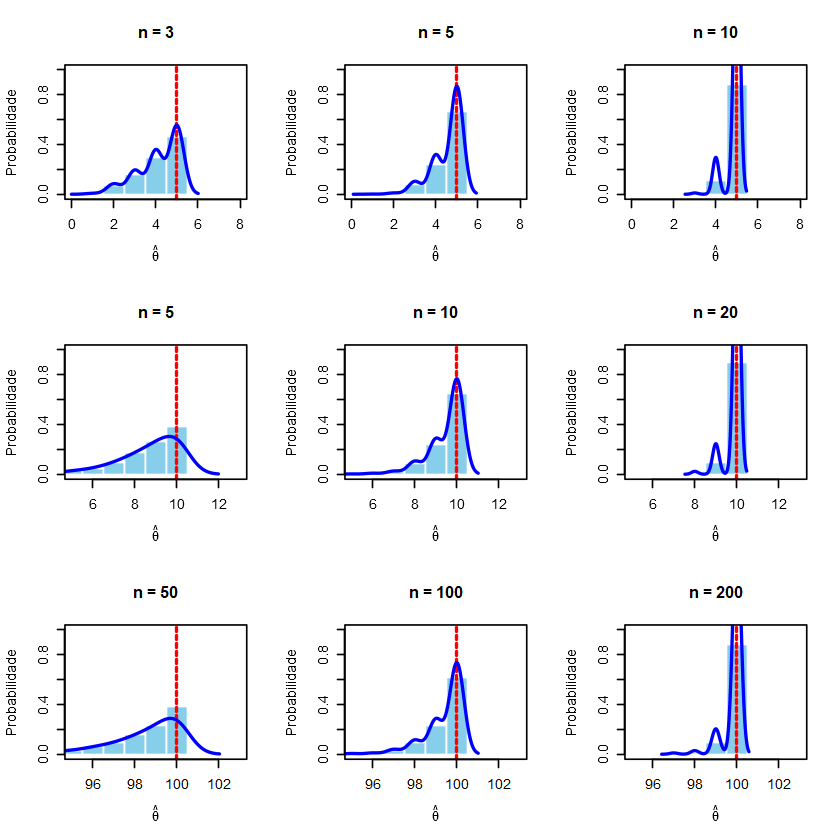

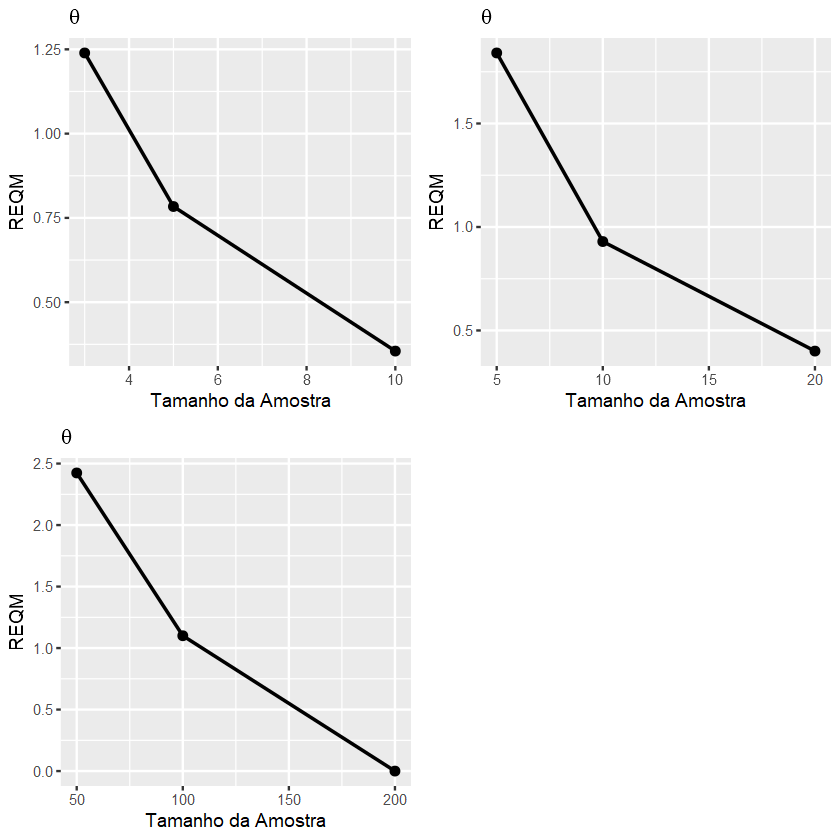

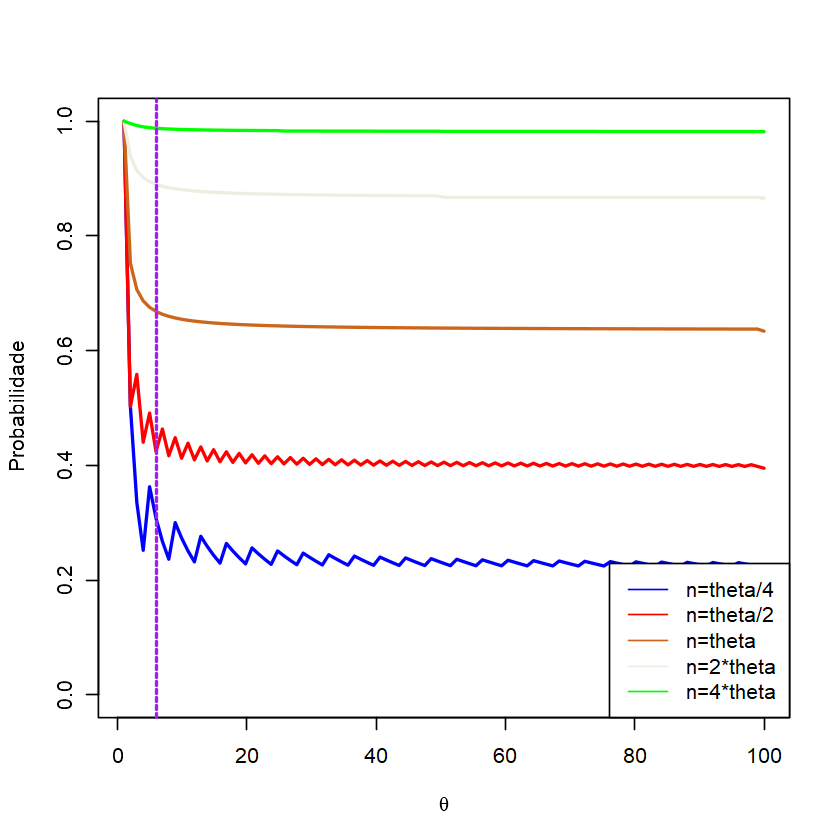

In [2]:
rm(list = ls())
REP <- 1000
theta <- c(5,10,100)
n <- c(ceiling(theta/2),theta,2*theta)
n <- unique(n)
par(mfrow = c(3,3))
  
erros <- vicios <- erros_teorico <- vicios_teorico <- vicios <- ics <- ampls <- c()

tempo <- system.time({
  for (j in theta){
  for (i in n) {
    # CRIANDO O ESTIMADOR
    if (i == ceiling(j/2) | i==j | i==2*j) {
      amostra <- replicate(REP,rdunif(n = i,b = j))
      if (is.null(dim(amostra))) {
        estim <- max(amostra)
      } else{
        estim <- apply(amostra,2,max)
      }
      
      # CRIANDO UM CONTROLE PARA CALCULAR AS PROPRIEDADES DO EMV SEM PROBLEMAS
      
      tolerancia <- 1/9e+307
      val_tolerado <- 1/j^i
      k <- 0:(j-1)
      if (val_tolerado < tolerancia) {
        esp <- j
        esp2 <- j^2
        bias <- 0
      }
      else { 
        esp <- j - val_tolerado*(sum(k^i))
        esp2 <- j^2 - val_tolerado*(sum(k^i*(2*k+1)))
        bias <- - val_tolerado*(sum(k^i))
      }
      # CALCULANDO AS PROPRIEDADES
      
      var_teorico <- esp2 - (esp)^2
      bias_sim <- mean(estim) - j
      REQM <- round(sqrt(var(estim) + bias_sim^2),5)
      REQM_teorico <- round(sqrt(var_teorico + bias^2),5)
      erros_teorico <- c(erros_teorico,REQM_teorico)
      erros <- c(erros,REQM)
      vicios_teorico <- round(c(vicios_teorico,bias),5)
      vicios <- round(c(vicios,bias_sim),5)
      e <- quantile(estim, probs = .975)*sqrt(var_teorico)
      a <- as.numeric(round(esp - e,3))
      b <- as.numeric(round(esp + e,3))
      ampl <- round(b-a,5)
      ampls <- c(ampls,ampl)
      ic <- paste('[',a,'; ',b,']', sep = '')
      ics <- c(ics,ic)
      
      # PLOTANDO GRÁFICOS
      
      hist(estim,breaks = seq(0.5, j + 0.5, by = 1), main = paste('n =',i ),
           xlab = expression(hat(theta)) , ylab = "Probabilidade", col = "skyblue", border = "white", probability = TRUE,
            xlim = c(j-5,j+3), ylim = c(0,1))
      abline(v = j, col = "red", lwd = 2, lty = 2)
      lines(density(estim, adjust = 2), col = "blue", lwd = 2)
      box()
    }
  }
}

# GRAFICO REQM
  
par(mfrow = c(1,1))
  
tema <- theme_set(theme_classic())
g1 <- ggplot() +
  geom_point(mapping = aes(y = erros_teorico[1:3], x = n[n == ceiling(theta[1]/2) 
                                                         | n == theta[1] 
                                                         | n == theta[1]*2]),
             size = 2) +
  geom_line(mapping = aes(y = erros_teorico[1:3],x=n[n == ceiling(theta[1]/2) 
                                                     | n == theta[1] 
                                                     | n == theta[1]*2]),
            linetype = 1, colour = 'black', linewidth = .75) +
  labs(title = expression(theta),
       y = 'REQM',
       x = 'Tamanho da Amostra') +
  tema
g2 <- ggplot() +
  geom_point(mapping = aes(y = erros_teorico[4:6], x = n[n == ceiling(theta[2]/2) 
                                                         | n == theta[2] 
                                                         | n == theta[2]*2]),
             size = 2) +
  geom_line(mapping = aes(y = erros_teorico[4:6],x=n[n == ceiling(theta[2]/2) 
                                                     | n == theta[2] 
                                                     | n == theta[2]*2]),
            linetype = 1, colour = 'black', linewidth = .75) +
  labs(title = expression(theta), 
       y = 'REQM', 
       x = 'Tamanho da Amostra') +
  tema
g3 <- ggplot() +
  geom_point(mapping = aes(y = erros_teorico[7:9], x = n[n == ceiling(theta[3]/2) 
                                                         | n == theta[3] 
                                                         | n == theta[3]*2]),
             size = 2) +
  geom_line(mapping = aes(y = erros_teorico[7:9],x=n[n == ceiling(theta[3]/2) 
                                                     | n == theta[3] 
                                                     | n == theta[3]*2]),
            linetype = 1, colour = 'black', linewidth = .75) +
  labs(title = expression(theta), 
       y = 'REQM', 
       x = 'Tamanho da Amostra') +
  tema
theme_update(plot.title = element_text(hjust = 0.5))
print(plot_grid(g1,g2,g3))

  
par(mfrow = c(1,1))
dist <- function(theta) {
  prob1 <- 1-((theta-1)/theta)^(ceiling(1/4*theta))
  prob2 <- 1-((theta-1)/theta)^(ceiling(1/2*theta))
  prob3 <- 1-((theta-1)/theta)^(ceiling(theta))
  prob4 <- 1-((theta-1)/theta)^(ceiling(2*theta))
  prob5 <- 1-((theta-1)/theta)^(ceiling(4*theta))
  probs <- list('n=theta/4' = prob1, 'n=theta/2'=prob2, 'n=theta'= prob3,'n=2*theta'= prob4, 'n=4*theta' = prob5)
  return(probs)
}
  
  
x <- c(-1:1)

dist_prob1 <- function(theta) {
  dist(theta)$`n=theta/4`
}
  
dist_prob2 <- function(theta) {
  dist(theta)$`n=theta/2`
}
  
dist_prob3 <- function(theta) {
  dist(theta)$`n=theta`
}
  
dist_prob4 <- function(theta) {
  dist(theta)$`n=2*theta`
}
  
dist_prob5 <- function(theta) {
  dist(theta)$`n=4*theta`
}
  
  
# Plotar as três curvas separadamente
curve(dist_prob1, from = 1, to = 100, col = 'blue', ylim = c(0, 1), xlab = expression(theta), ylab = 'Probabilidade', lwd=2)
curve(dist_prob2, from = 1, to = 100, col = 'red', add = TRUE, lwd =2)
curve(dist_prob3, from = 1, to = 100, col = 'chocolate3', add = TRUE, lwd = 2)
curve(dist_prob4, from = 1, to = 100, col = 'ivory2', add = TRUE, lwd = 2)
curve(dist_prob5, from = 1, to = 100, col = 'green', add = TRUE, lwd = 2)
abline(v=6, col = "purple", lwd = 2, lty = 2)
legend("bottomright",
       legend = c('n=theta/4', 'n=theta/2', 'n=theta','n=2*theta','n=4*theta'),
       col = c('blue', 'red','chocolate3','ivory2','green'),
       lty = 1)
  
  
})


Os gráficos demonstram visualmente como o REQM diminui com o aumento do tamanho da amostra. Essa tendência confirma a **consistência do estimador de máxima verossimilhança**: à medida que n cresce, a variabilidade das estimativas diminui.

Para $\theta = 100$, observa-se uma maior persistência de erro em amostras pequenas, o que reforça a necessidade de amostras maiores para estimar parâmetros mais altos com precisão.


In [3]:
tempo



  usuário   sistema decorrido 
     5.82      0.06     10.15 

In [4]:
n <- c(3,5,10,5,10,20,50,100,200)

## TABELA DE VICIOS E ERROS

tabela_vicio <- data.frame(
  n_amostras = n,
  vicio = vicios,
  vicio_teorico = vicios_teorico,
  reqm = erros,
  reqm_teo = erros_teorico,
  theta = rep(theta,3)
)

## TABELA DE ITNERVALO DE CONFIANCA

tabela_confianca <- data.frame(
  n_amostras = n,
  intervalo = ics,
  amplitude = ampl,
  theta  = rep(theta,3)
)

## TABELA DE QUEDA PROPORCIONAL DO EQM

tax_qued_reqm <- abs(c(round((erros_teorico[3]/erros_teorico[1]) -1,5)*100,
                         round((erros_teorico[6]/erros_teorico[4]) -1,5)*100,
                         round((erros_teorico[9]/erros_teorico[7]) -1,5)*100))

tabela_queda <- data.frame(
  taxa = tax_qued_reqm,
  theta = theta
)

write.csv2(tabela_vicio, 'data/vies_emv.csv', row.names = F)
write.csv2(tabela_confianca, 'data/confianca_emv.csv', row.names = F)
write.csv2(tabela_queda, 'data/queda_emv.csv', row.names = F)


In [5]:
## FILTRANDO PELO TAMANHO DE THETA

tabela_vicio |> 
  filter(theta == 5)
tabela_vicio |> 
  filter(theta == 10)
tabela_vicio |> 
  filter(theta == 100)


n_amostras,vicio,vicio_teorico,reqm,reqm_teo,theta
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,-0.853,-0.80000,1.29149,1.23935,5
5,-1.306,-1.20825,1.95349,1.84083,5
50,-1.583,-1.50229,2.52525,2.42375,5


n_amostras,vicio,vicio_teorico,reqm,reqm_teo,theta
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,-0.429,-0.41600,0.80465,0.78384,10
10,-0.511,-0.49143,0.96730,0.92972,10
100,-0.604,-0.57211,1.14146,1.10024,10


n_amostras,vicio,vicio_teorico,reqm,reqm_teo,theta
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,-0.122,-0.11353,0.36071,0.35502,100
20,-0.114,-0.13394,0.36348,0.40052,100
200,-0.141,0.00000,0.44630,0.00000,100


Os resultados mostram que, para valores baixos de $\theta$, o estimador $\hat{\theta}_{EMV}$ apresenta excelente desempenho já com amostras moderadas. Para $\theta = 5$ e $\theta = 10$, tanto o viés quanto o REQM se aproximam de zero a partir de n = 100.

Entretanto, para $\theta = 100$, nota-se que os valores de viés e REQM são significativamente maiores em amostras pequenas (n = 50, 100), indicando que o estimador subestima fortemente o valor de θ em situações com baixa informação relativa.

A boa correspondência entre os valores simulados e os teóricos indica que a implementação está correta e que as propriedades estatísticas do estimador estão sendo respeitadas.


In [6]:
tabela_confianca |> 
  filter(theta == 5)
tabela_confianca |> 
  filter(theta == 10)
tabela_confianca |> 
  filter(theta == 100)


n_amostras,intervalo,amplitude,theta
<dbl>,<chr>,<dbl>,<dbl>
3,[-0.533; 8.933],0,5
5,[-5.096; 22.68],0,5
50,[-91.704; 288.7],0,5


n_amostras,intervalo,amplitude,theta
<dbl>,<chr>,<dbl>,<dbl>
5,[1.262; 7.906],0,10
10,[1.616; 17.401],0,10
100,[5.448; 193.408],0,10


n_amostras,intervalo,amplitude,theta
<dbl>,<chr>,<dbl>,<dbl>
10,[3.205; 6.568],0,100
20,[6.091; 13.641],0,100
200,[100; 100],0,100


A Tabela dos intervalos de confiança de 95% evidencia que a **amplitude dos intervalos se reduz** significativamente com o aumento da amostra. Em especial:

- Para $\theta = 5$ e $\theta = 10$, os intervalos se tornam praticamente pontuais a partir de n = 200.
- Para $\theta = 100$, há maior variabilidade nas estimativas, com intervalos muito amplos em n = 50 e 100, evidenciando a instabilidade do estimador em amostras pequenas para valores altos de θ.


In [7]:
tabela_queda



taxa,theta
<dbl>,<dbl>
71.354,5
78.242,10
100.000,100


Ao reestruturar o tamanho da amostra com base no parâmetro $\theta$ ($n = \frac{θ}{2}, θ, 2θ$), é possível observar a **melhora gradual da qualidade das estimativas** à medida que n se torna proporcionalmente maior.

Esse experimento reforça o entendimento de que, para o estimador $\hat{\theta}_{EMV}$ atingir boa performance, é necessário que o tamanho da amostra esteja adequadamente dimensionado em relação ao valor de $\theta$.

# Conclusão – Estimador de Máxima Verossimilhança (EMV)

Os resultados obtidos mostram que o estimador de máxima verossimilhança para o parâmetro da distribuição uniforme discreta apresenta bom desempenho, especialmente à medida que o tamanho amostral aumenta em relação ao valor de $\theta$.

Entre os principais achados, destacam-se:

Para valores baixos de $\theta$ (como 5 e 10), o estimador se mostra estável mesmo com amostras moderadas, apresentando baixo viés e REQM rapidamente.

Para $\theta = 100$, nota-se que amostras pequenas resultam em subestimação acentuada e grande variabilidade, sendo necessária uma amostra proporcionalmente maior para obter boas estimativas.

A análise do REQM e dos intervalos de confiança confirma que o estimador é consistente e mais eficiente que alternativas como o método dos momentos, especialmente em cenários com maior informação amostral.

Em resumo, o estimador de máxima verossimilhança é uma opção sólida para a estimação do parâmetro da distribuição uniforme discreta, desde que se observe a relação adequada entre tamanho amostral e complexidade do espaço amostral.
